# RL Assignment 1

In [1]:
# Install the required packages
!pip install gymnasium matplotlib numpy pandas

## Part 1: Defining RL Environments

In [2]:
# Import required libraries
import gymnasium
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from enum import Enum
import pickle
import math

/var/folders/nx/7cy8wjn91wz5trfd0myjdwx40000gn/T/ipykernel_55672/3993538664.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### 1.1: Deterministic Environment

In [3]:
# Action ENUM
class Action(Enum):
    DOWN = 0
    UP = 1
    RIGHT = 2
    LEFT = 3

In [4]:
"""
Definition of the Grid Env class.

References: RL Env Creation and Random Agent Demo
"""
class DeterministicGridEnv(gymnasium.Env):
    # Attribute of a Gym class that provides info about the render modes
    metadata = { 'render.modes': [] }

    # Initialization function
    def __init__(self, rows, cols, max_timesteps, start_pos, goal_pos, rewards_map):

      self.observation_space = spaces.Discrete(rows*cols)
      self.action_space = spaces.Discrete(4)
      self.max_timesteps = max_timesteps
      self.rows = rows
      self.cols = cols
      self.start_pos = start_pos
      self.goal_pos = goal_pos
      self.rewards_map = rewards_map

      self.timestep = 0
      self.reset()

    # Reset function
    def reset(self):
      self.state = np.zeros((self.rows, self.cols))
      self.agent_pos = self.start_pos.copy()
      self.state[tuple(self.agent_pos)] = 1
      self.state[tuple(self.goal_pos)] = 0.5
      observation = self.state.flatten()
      self.timestep = 0

      info = {}

      return observation, info

    # Step function: Contains the implementation for what happens when an
    # agent takes a step in the environment.
    def step(self, action):
      next_pos = self.agent_pos.copy()

      if action == Action.DOWN.value:
        next_pos[0] += 1
      elif action == Action.UP.value:
        next_pos[0] -= 1
      elif action == Action.RIGHT.value:
        next_pos[1] += 1
      elif action == Action.LEFT.value:
        next_pos[1] -= 1

      if 0 <= next_pos[0] < self.rows and 0 <= next_pos[1] < self.cols:
        self.agent_pos = next_pos

      self.state = np.zeros((self.rows, self.cols))
      self.state[tuple(self.agent_pos)] = 1
      self.state[tuple(self.goal_pos)] = 0.5
      observation = self.state.flatten()
      info = {}

      # check rewards map for reward
      reward = -1
      if tuple(self.agent_pos) in self.rewards_map:
        reward = self.rewards_map[tuple(self.agent_pos)]

      self.timestep += 1

      # Condition to check for termination (episode is over)
      terminated = True if ((self.timestep >= self.max_timesteps) or np.array_equal(self.agent_pos, self.goal_pos)) else False

      # Condition to check if agent is traversing to a cell beyond the permitted cells
      # This helps the agent to learn how to behave in a safe and predictable manner
      truncated = False if (0 <= self.agent_pos[0] < self.rows and 0 <= self.agent_pos[1] < self.cols) else True
      
      return observation, reward, terminated, truncated, info

    # Render function: Visualizes the environment
    def render(self):
      plt.figure()
      plt.title('Grid Environment')
      plt.imshow(self.state)
  

In [5]:
"""
Definition an agent that takes action randomly

References: RL Env Creation and Random Agent Demo
"""
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, obs):
    """Takes a step in the environment by choosing an action randomly.

    Args:
        obs: The current observation.

    Returns:
        The action to take.
    """
    return self.env.action_space.sample()

In [6]:
# Define 4 rewards for the agent to collect
rewards_map = {
    (0, 1): 1,
    (2, 1): -2,
    (1, 3): 3,
    (2, 3): 10
}

# Initialize the environment
d_env = DeterministicGridEnv(3, 4, 10, [0, 0], [2, 3], rewards_map)

# Initialize the agent
random_agent = RandomAgent(d_env)

Timestep: 1 , State: [0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5] , Action: RIGHT , Reward: 1
Timestep: 2 , State: [1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5] , Action: LEFT , Reward: -1
Timestep: 3 , State: [1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5] , Action: LEFT , Reward: -1
Timestep: 4 , State: [1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5] , Action: LEFT , Reward: -1
Timestep: 5 , State: [1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5] , Action: UP , Reward: -1
Timestep: 6 , State: [0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.5] , Action: DOWN , Reward: -1
Timestep: 7 , State: [1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5] , Action: UP , Reward: -1
Timestep: 8 , State: [0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.5] , Action: DOWN , Reward: -1
Timestep: 9 , State: [1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5] , Action: UP , Reward: -1
Timestep: 10 , State: [1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5] , Action: UP , Reward: -1


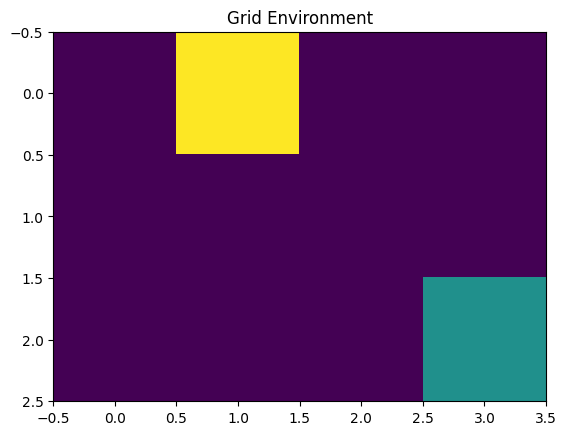

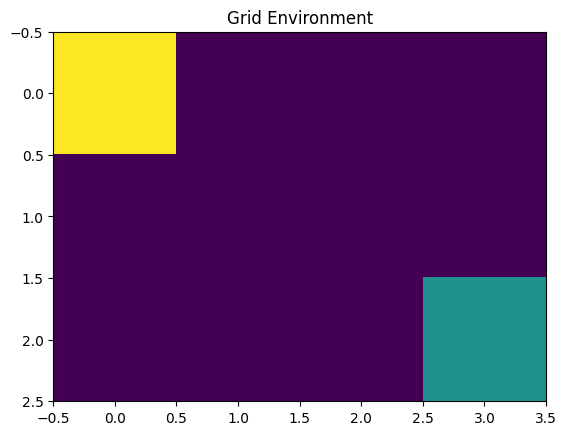

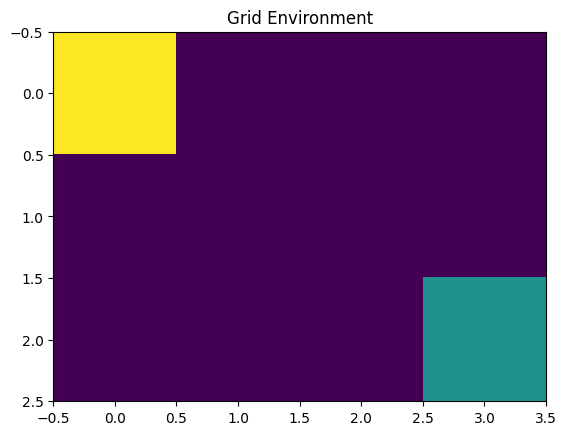

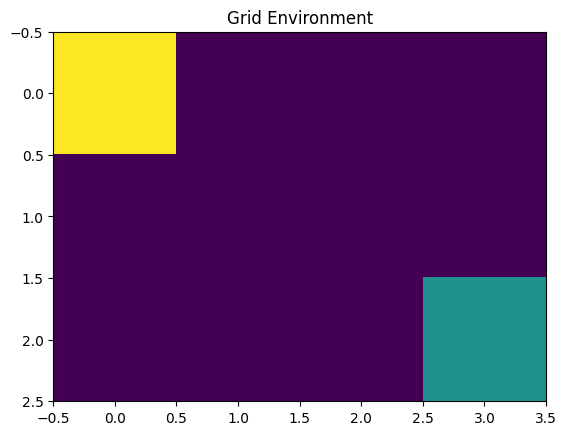

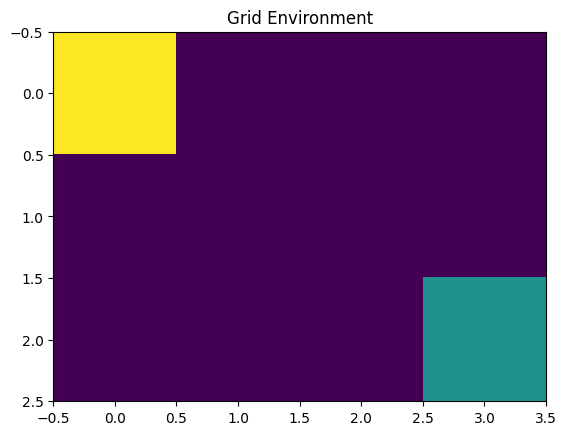

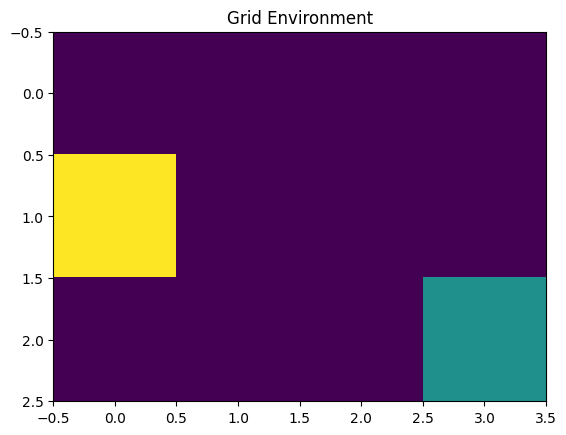

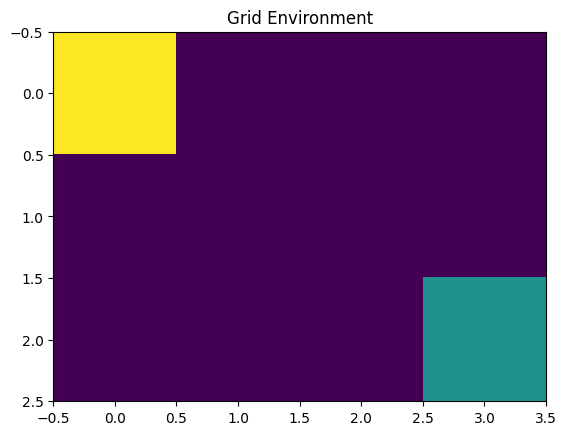

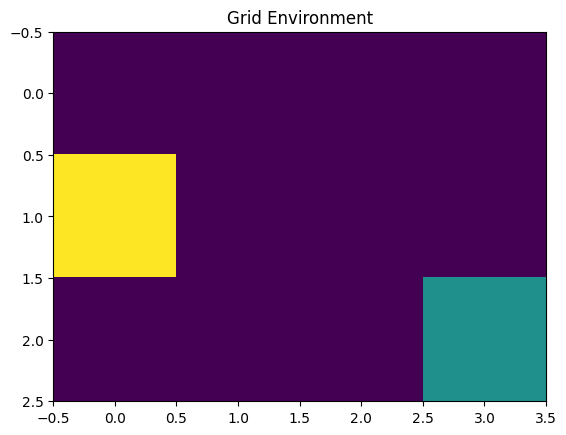

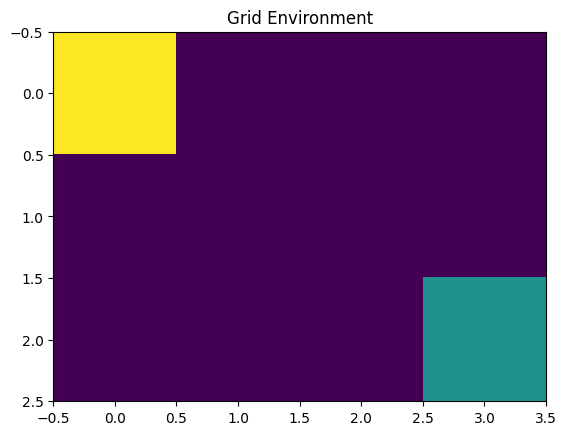

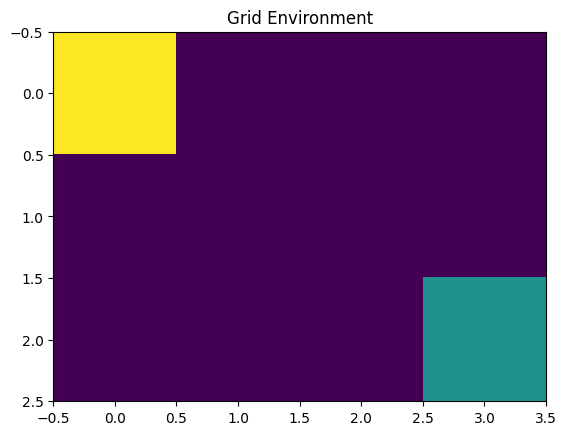

In [7]:
obs, info = d_env.reset()
terminated, truncated = False, False

for _ in range(10):
    action = random_agent.step(obs)
    obs, reward, terminated, truncated, info = d_env.step(action)
    print('Timestep:', d_env.timestep, ', State:', obs, ', Action:', Action(action).name, ', Reward:', reward)
    d_env.render()

### Part 1.2: Stochastic Environment

In [8]:
"""
Definition of the Stochastic Grid Env class.
Extend the DeterministicGridEnv class to include stochasticity in the environment.
"""
class StochasticGridEnv(DeterministicGridEnv):
  def __init__(self, rows, cols, max_timesteps, agent_pos, goal_pos, rewards_map, p_stochastic):
    super().__init__(rows, cols, max_timesteps, agent_pos, goal_pos, rewards_map)
    self.p_stochastic = p_stochastic

  def step(self, action):
    if np.random.rand() < self.p_stochastic:
      action = self.action_space.sample()

    return super().step(action)

In [9]:
# Define 4 rewards for the agent to collect
rewards_map = {
    (0, 1): 1,
    (2, 1): -2,
    (1, 3): 3,
    (2, 3): 10
}

# Initialize the environment
s_env = StochasticGridEnv(3, 4, 10, [0, 0], [2, 3], rewards_map, 0.1)

# Initialize the agent
random_agent = RandomAgent(s_env)

Timestep: 1 , State: [1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5] , Action: UP , Reward: -1
Timestep: 2 , State: [0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5] , Action: RIGHT , Reward: 1
Timestep: 3 , State: [0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.5] , Action: RIGHT , Reward: -1
Timestep: 4 , State: [0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.5] , Action: UP , Reward: -1
Timestep: 5 , State: [0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5] , Action: LEFT , Reward: 1
Timestep: 6 , State: [0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.5] , Action: RIGHT , Reward: -1
Timestep: 7 , State: [0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.5] , Action: RIGHT , Reward: -2
Timestep: 8 , State: [0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.5] , Action: LEFT , Reward: -1
Timestep: 9 , State: [0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.5] , Action: LEFT , Reward: -1
Timestep: 10 , State: [0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.5] , Action: UP , Reward: -1


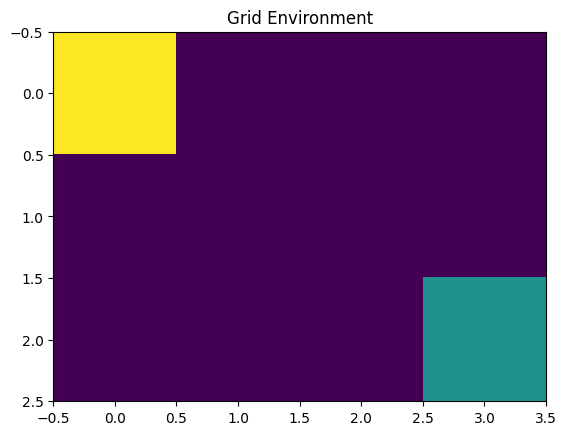

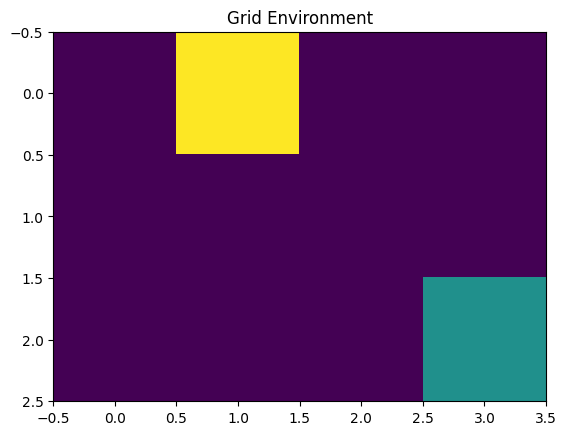

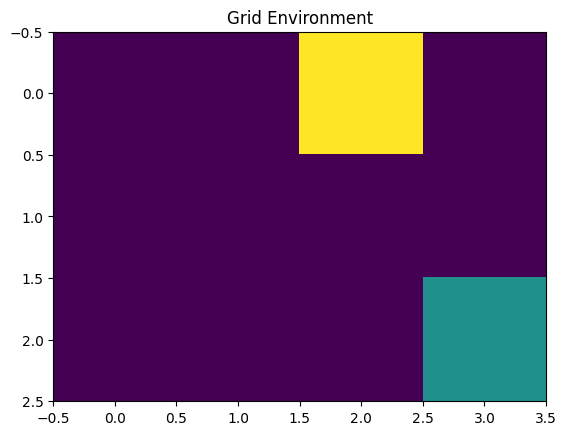

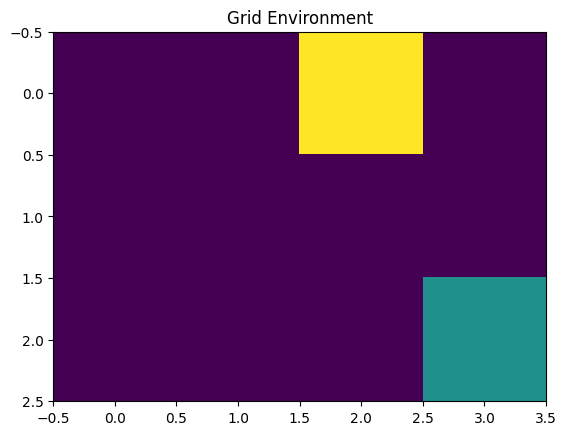

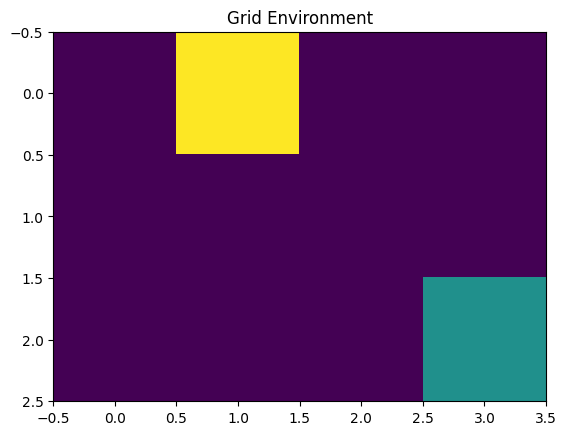

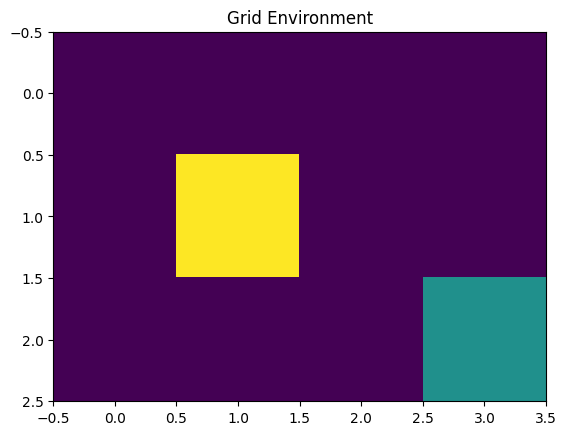

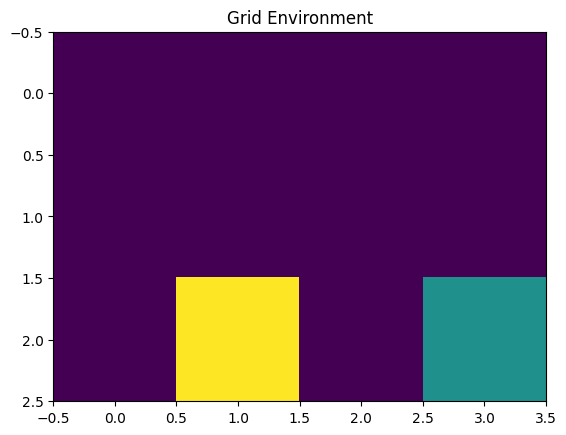

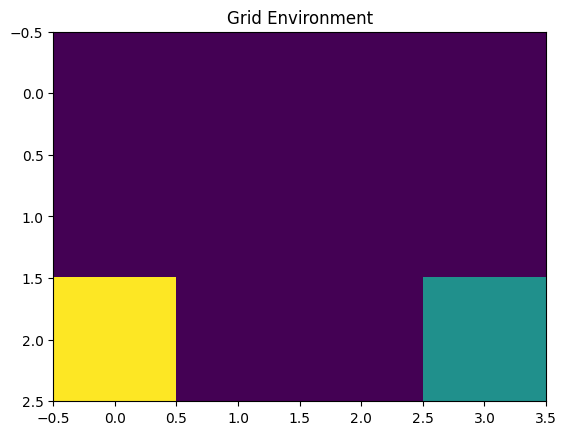

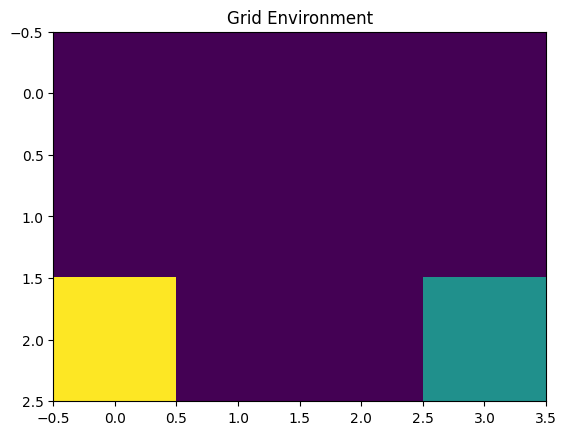

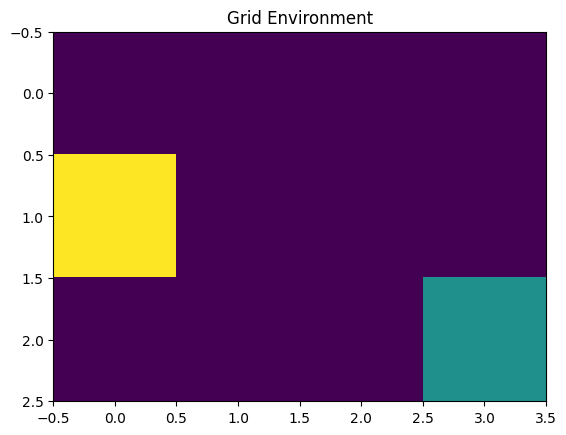

In [10]:
obs, info = s_env.reset()
terminated, truncated = False, False

for _ in range(10):
    action = random_agent.step(obs)
    obs, reward, terminated, truncated, info = s_env.step(action)
    print('Timestep:', s_env.timestep, ', State:', obs, ', Action:', Action(action).name, ', Reward:', reward)
    s_env.render()

## Part 2 - Applying Tabular Methods

### 2.1: Q-learning

In [11]:
"""
Definition of the Q-Learning Agent class.

References: https://github.com/vmayoral/basic_reinforcement_learning/tree/master/tutorial4
"""
class QLearningAgent:
  def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=1, epsilon_decay=None):
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.epsilon = epsilon
    self.epsilon_decay = epsilon_decay
    self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
    
    self._episodes_completed = 0

  def choose_action(self, obs):
    """Takes a step in the environment by choosing an action based on the Q-table.

    Args:
        obs: The current observation.

    Returns:
        The action to take.
    """
    if np.random.rand() < self.epsilon:
      return self.env.action_space.sample()
    return np.argmax(self.q_table[self._get_agent_pos(obs)])

  def _get_agent_pos(self, obs):
    """Gets the agent's position from the observation.

    Args:
        obs: The observation.

    Returns:
        The agent's position.
    """
    return np.argmax(obs)

  def _update_q_table(self, obs, action, reward, next_obs, terminated):
    """Updates the Q-table based on the observed transition.

    Args:
        obs: The previous observation.
        action: The action taken.
        reward: The reward received.
        next_obs: The next observation.
        terminated: Whether the episode terminated.
    """
    if terminated:
      target = reward
    else:
      target = reward + self.gamma * np.max(self.q_table[self._get_agent_pos(next_obs)])

    self.q_table[self._get_agent_pos(obs), action] = (1-self.alpha) * self.q_table[self._get_agent_pos(obs), action] + \
                                                     self.alpha * target

  def train(self, num_episodes):
    """Trains the agent for a number of episodes.

    Args:
        num_episodes: The number of episodes to train for.

    Returns:
        The rewards obtained during training and the epsilon history.
    """
    rewards = []
    epsilon_history = []
    # epsilon_decay = (final_epsoilon / initial_epsilon) ** (1 / num_episodes)
    if self.epsilon_decay is None:
      self.epsilon_decay = (0.001 / self.epsilon) ** (1 / num_episodes)

    for episode in range(num_episodes):
      obs, info = self.env.reset()
      terminated = False
      episode_reward = 0
      epsilon_history.append(self.epsilon)

      while not terminated:
        action = self.choose_action(obs)
        next_obs, reward, terminated, truncated, info = self.env.step(action)
        self._update_q_table(obs, action, reward, next_obs, terminated)
        obs = next_obs
        episode_reward += reward
      self._episodes_completed += 1

      rewards.append(episode_reward)
      self.epsilon *= self.epsilon_decay

    return rewards, epsilon_history

  def save_q_table(self, filename):
    """Saves the Q-table to a file.

    Args:
        filename: The name of the file to save the Q-table to.
    """
    with open(filename, 'wb') as f:
      pickle.dump(self.q_table, f)

  def load_q_table(self, filename):
    """Loads the Q-table from a file.

    Args:
        filename: The name of the file to load the Q-table from.
    """
    with open(filename, 'rb') as f:
      self.q_table = pickle.load(f)
  

### Deterministic Environment

In [12]:
# Init q-learning agent for deterministic environment
qlearning_agent = QLearningAgent(d_env)


In [13]:
# print init q-table for deterministic environment
print(qlearning_agent.q_table)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [14]:
# Train the agent
reward_per_episode, epsilon_history = qlearning_agent.train(1000)

# Save the Q-table
qlearning_agent.save_q_table('qlearning_q_table_det.pkl')

# Load the Q-table
qlearning_agent.load_q_table('qlearning_q_table_det.pkl')

In [15]:
# print trained q-table for deterministic environment
print(qlearning_agent.q_table)

[[ 1.94794299  3.32633512  5.21261342  3.6899178 ]
 [ 3.209925    4.6896948   2.19545697  2.9836933 ]
 [ 2.44120594  2.55331902  1.01429351  4.61416291]
 [ 5.01594765  0.16441794 -0.17455087 -0.11712859]
 [-0.85502845  3.52213936  0.85118599 -0.33647352]
 [-1.49844349  5.01654057  1.71100183  0.60373298]
 [-0.40951     0.01148457  7.8307686   0.35131342]
 [ 9.0152291  -0.1589419   2.13582229  0.31388204]
 [-0.75804456  0.16256646 -0.79558471 -0.6746334 ]
 [-0.77915994  0.7547252  -0.3439     -0.71104957]
 [-0.1        -0.2884123   0.         -0.4052    ]
 [ 0.          0.          0.          0.        ]]


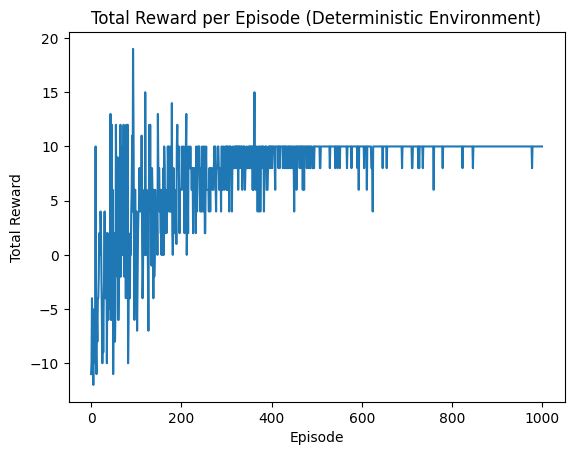

In [16]:
# Plot the total reward per episode graph
plt.plot(reward_per_episode)
plt.title('Total Reward per Episode (Deterministic Environment)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

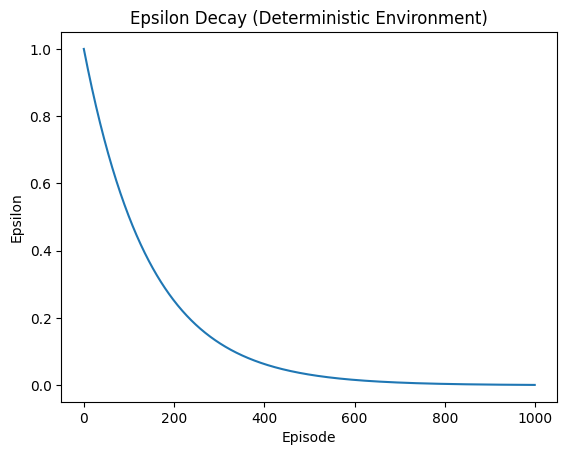

In [17]:
# Plot the epsilon decay graph
plt.plot(epsilon_history)
plt.title('Epsilon Decay (Deterministic Environment)')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

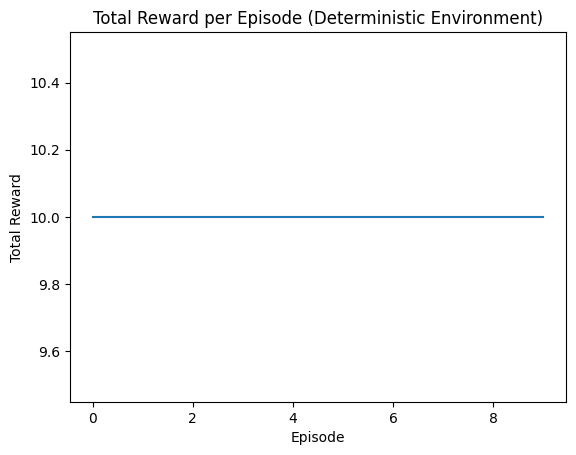

In [18]:
# Run your environment for at least 10 episodes, where the agent chooses only greedy actions from the learned policy
qlearning_agent.epsilon = 0
reward_per_episode, _ = qlearning_agent.train(10)

# Plot the total reward per episode graph
plt.plot(reward_per_episode)
plt.title('Total Reward per Episode (Deterministic Environment)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

In [19]:
def q_learning_with_hyperparameters(env, discount_factor, epsilon_decay_rate, episodes=1000, max_steps=100):
    qlearning_agent = QLearningAgent(env, gamma=discount_factor, epsilon_decay=epsilon_decay_rate)
    rewards_per_episode = qlearning_agent.train(num_episodes=episodes)
    return rewards_per_episode

In [20]:
# Hyperparameter tuning for Q-learning agent

discount_factors = [0.7, 0.8, 0.9, 0.95, 0.99]
epsilon_decay_rates = [0.97, 0.98, 0.99, 0.995, 0.999]

# store the rewards per episode for each hyperparameter combination in dataframe
df = pd.DataFrame(columns=['Discount Factor', 'Epsilon Decay Rate', 'Average Reward'])

# loop through all hyperparameter combinations for deterministic environment
for i, discount_factor in enumerate(discount_factors):
    for j, epsilon_decay_rate in enumerate(epsilon_decay_rates):
        rewards = q_learning_with_hyperparameters(d_env, discount_factor, epsilon_decay_rate)
        average_reward = np.mean(rewards)
        df.loc[i*len(epsilon_decay_rates) + j] = [discount_factor, epsilon_decay_rate, average_reward]

# print the dataframe
print(df)
        

    Discount Factor  Epsilon Decay Rate  Average Reward
0              0.70               0.970        4.773667
1              0.70               0.980        4.673000
2              0.70               0.990        4.333498
3              0.70               0.995        3.572335
4              0.70               0.999        1.719652
5              0.80               0.970        4.742667
6              0.80               0.980        4.666000
7              0.80               0.990        4.352498
8              0.80               0.995        4.403335
9              0.80               0.999        2.025652
10             0.90               0.970        4.783167
11             0.90               0.980        4.641000
12             0.90               0.990        4.292498
13             0.90               0.995        3.777335
14             0.90               0.999        1.619152
15             0.95               0.970        4.786667
16             0.95               0.980        4

In [21]:
# get the hyperparameters with the highest average reward
best_hyperparameters = df.loc[df['Average Reward'].idxmax()]
print('Best Hyperparameters: \n', best_hyperparameters)

Best Hyperparameters: 
 Discount Factor       0.950000
Epsilon Decay Rate    0.970000
Average Reward        4.786667
Name: 15, dtype: float64


### Stochastic Environment

In [22]:
# Init q-learning agent for stochastic environment
qlearning_agent = QLearningAgent(s_env)

In [23]:
# print init q-table for stochastic environment
print(qlearning_agent.q_table)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [24]:
# Train the agent
reward_per_episode, epsilon_history = qlearning_agent.train(1000)

# Save the Q-table
qlearning_agent.save_q_table('qlearning_q_table_sto.pkl')

# Load the Q-table
qlearning_agent.load_q_table('qlearning_q_table_sto.pkl')


In [25]:
# print trained q-table for stochastic environment
print(qlearning_agent.q_table)

[[ 1.31509099  3.04814239  4.30218262  2.51575316]
 [ 1.91341401  4.12637705  2.32206779  2.72946023]
 [ 1.39752213  1.7377515   1.12461659  4.33731432]
 [ 6.12022314 -0.15648258 -0.02931613  0.33944998]
 [-0.84670263  2.46551496  1.12393841 -0.01392732]
 [-1.32835939  4.09662958  1.90769003  0.44742289]
 [ 0.05402069  0.16721406  7.21916468  0.68637339]
 [ 3.439      -0.05646296  6.76367203  0.8293026 ]
 [-0.96189468 -0.27348188 -1.48434044 -0.70501825]
 [-0.49690336  0.10883506  2.57360249 -0.78412767]
 [ 0.29814255  0.22700518  7.83966823  0.7       ]
 [ 0.          0.          0.          0.        ]]


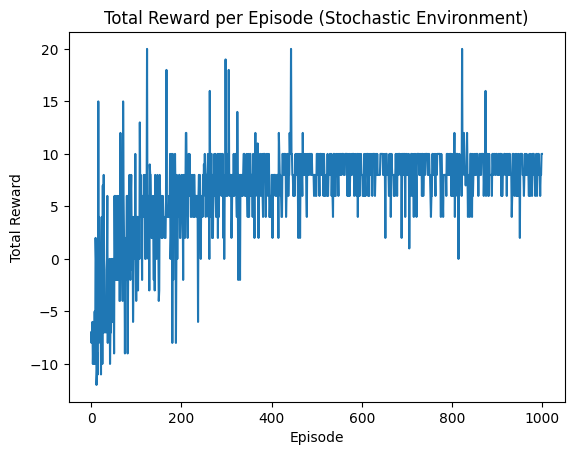

In [26]:
# Plot the total reward per episode graph
plt.plot(reward_per_episode)
plt.title('Total Reward per Episode (Stochastic Environment)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

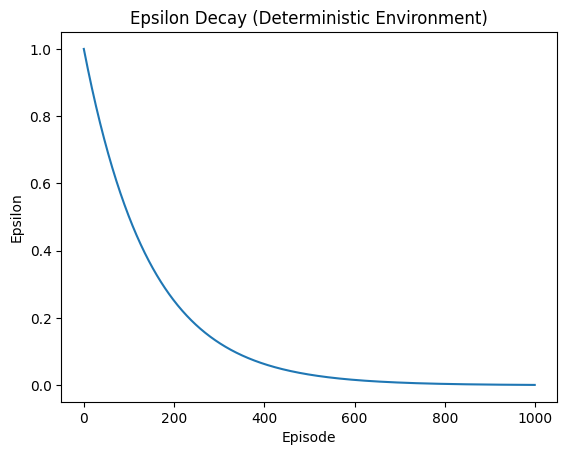

In [27]:
# Plot the epsilon decay graph
plt.plot(epsilon_history)
plt.title('Epsilon Decay (Deterministic Environment)')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

In [28]:
# Hyperparameter tuning for Q-learning agent

discount_factors = [0.7, 0.8, 0.9, 0.95, 0.99]
epsilon_decay_rates = [0.97, 0.98, 0.99, 0.995, 0.999]

# store the rewards per episode for each hyperparameter combination in dataframe
df = pd.DataFrame(columns=['Discount Factor', 'Epsilon Decay Rate', 'Average Reward'])

# loop through all hyperparameter combinations for stochastic environment
for i, discount_factor in enumerate(discount_factors):
    for j, epsilon_decay_rate in enumerate(epsilon_decay_rates):
        rewards = q_learning_with_hyperparameters(s_env, discount_factor, epsilon_decay_rate)
        average_reward = np.mean(rewards)
        df.loc[i*len(epsilon_decay_rates) + j] = [discount_factor, epsilon_decay_rate, average_reward]

# print the dataframe
print(df)
        

    Discount Factor  Epsilon Decay Rate  Average Reward
0              0.70               0.970        4.130167
1              0.70               0.980        3.936000
2              0.70               0.990        3.647998
3              0.70               0.995        3.718335
4              0.70               0.999        1.257152
5              0.80               0.970        4.132667
6              0.80               0.980        3.929500
7              0.80               0.990        3.649498
8              0.80               0.995        3.092335
9              0.80               0.999        1.165152
10             0.90               0.970        4.016167
11             0.90               0.980        3.952000
12             0.90               0.990        3.618998
13             0.90               0.995        3.925335
14             0.90               0.999        1.337652
15             0.95               0.970        4.048667
16             0.95               0.980        3

In [29]:
# get the hyperparameters with the highest average reward
best_hyperparameters = df.loc[df['Average Reward'].idxmax()]
print('Best Hyperparameters: \n', best_hyperparameters)

Best Hyperparameters: 
 Discount Factor       0.800000
Epsilon Decay Rate    0.970000
Average Reward        4.132667
Name: 5, dtype: float64


### Part 2.2: SARSA

In [30]:
# Apply any other tabular method to solve both the deterministic and stochastic environments that 
# were defined in Part 1. E.g. SARSA, Double Q-learning, Monte Carlo, n-step bootstrapping, etc.

In [31]:
"""
Definition of the SARSA Agent class.

References: https://builtin.com/machine-learning/sarsa
"""
class SARSAAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=1, epsilon_decay=None):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
        
    def choose_action(self, obs):
        """
        Chooses an action based on the Q-table.

        Args:
            obs: The current observation.

        Returns:
            The action to take.
        """
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.q_table[self._get_agent_pos(obs)])
    
    def _get_agent_pos(self, obs):
        """
        Gets the agent's position from the observation.

        Args:
            obs: The observation.

        Returns:
            The agent's position.
        """
        return np.argmax(obs)
    
    def update_q_table(self, obs, action, reward, next_obs, next_action, terminated):
        """
        Updates the Q-table based on the observed transition.

        Args:
            obs: The previous observation.
            action: The action taken.
            reward: The reward received.
            next_obs: The next observation.
            next_action: The next action.
        """
        if terminated:
            target = reward
        else:
            target = reward + self.gamma * self.q_table[self._get_agent_pos(next_obs), next_action]
        
        self.q_table[self._get_agent_pos(obs), action] = (1-self.alpha) * self.q_table[self._get_agent_pos(obs), action] +\
                                                         self.alpha * target

    
    def train(self, num_episodes):
        """
        Trains the agent for a number of episodes.

        Args:
            num_episodes: The number of episodes to train for.

        Returns:
            The rewards obtained during training and the epsilon history.
        """
        rewards = []
        epsilon_history = []
        # epsilon_decay = (final_epsoilon / initial_epsilon) ** (1 / num_episodes)
        if self.epsilon_decay is None:
            self.epsilon_decay = (0.001 / self.epsilon) ** (1 / num_episodes)
        
        for episode in range(num_episodes):
            obs, info = self.env.reset()
            terminated = False
            action = self.choose_action(obs)
            episode_reward = 0
            epsilon_history.append(self.epsilon)
            
            while not terminated:
                next_obs, reward, terminated, truncated, info  = self.env.step(action)
                next_action = self.choose_action(next_obs)
                self.update_q_table(obs, action, reward, next_obs, next_action, terminated)
                obs = next_obs
                action = next_action
                episode_reward += reward
            
            rewards.append(episode_reward)
            self.epsilon *= self.epsilon_decay
        
        return rewards, epsilon_history
    
    def save_q_table(self, filename):
        """
        Saves the Q-table to a file.

        Args:
            filename: The name of the file to save the Q-table to.
        """
        with open(filename, 'wb') as f:
            pickle.dump(self.q_table, f)

    def load_q_table(self, filename):
        """
        Loads the Q-table from a file.

        Args:
            filename: The name of the file to load the Q-table from.
        """
        with open(filename, 'rb') as f:
            self.q_table = pickle.load(f)


### Deterministic Environment

In [32]:
# Init SARSA agent for deterministic environment
sarsa_agent = SARSAAgent(d_env)

In [33]:
# print init q-table for deterministic environment
print(sarsa_agent.q_table)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [34]:
sarsa_agent.q_table[2, 2]

0.0

In [35]:
# Train the agent
reward_per_episode, epsilon_history = sarsa_agent.train(1000)

# Save the Q-table
sarsa_agent.save_q_table('sarsa_q_table_det.pkl')

# Load the Q-table
sarsa_agent.load_q_table('sarsa_q_table_det.pkl')

In [36]:
# print trained q-table for deterministic environment
print(sarsa_agent.q_table)

[[-0.9378711   0.69562947  5.14200701  2.23680796]
 [ 2.53061206  4.62274667  2.00695862  2.88013083]
 [ 1.9758761   0.11871656  0.05954458  4.24296275]
 [ 4.82855175 -0.03756373 -0.2611041  -0.23829184]
 [-1.30267193  1.67919524 -0.87838398 -1.48568815]
 [-1.40638041  4.24396913  1.21899226 -1.24898905]
 [-0.05149    -0.60410778  7.31216717 -0.44750129]
 [ 9.11370619  0.0119705   2.1169494   0.48614588]
 [-1.2643762  -1.13579801 -1.21626972 -1.16351308]
 [-0.98642587 -0.54118551  1.23244275 -0.63066522]
 [ 0.7405878   0.31748694  7.71232075 -0.43855193]
 [ 0.          0.          0.          0.        ]]


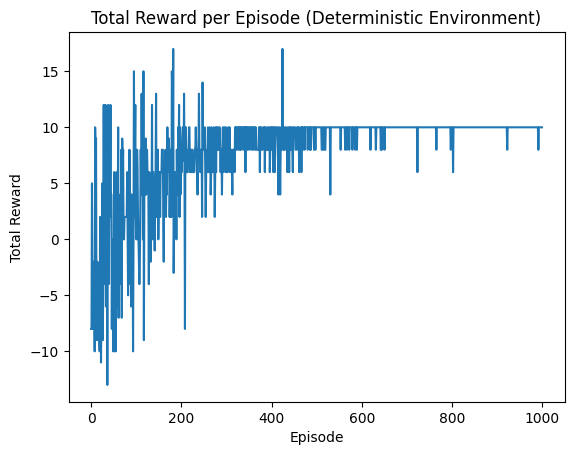

In [37]:
# Plot the total reward per episode graph
plt.plot(reward_per_episode)
plt.title('Total Reward per Episode (Deterministic Environment)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

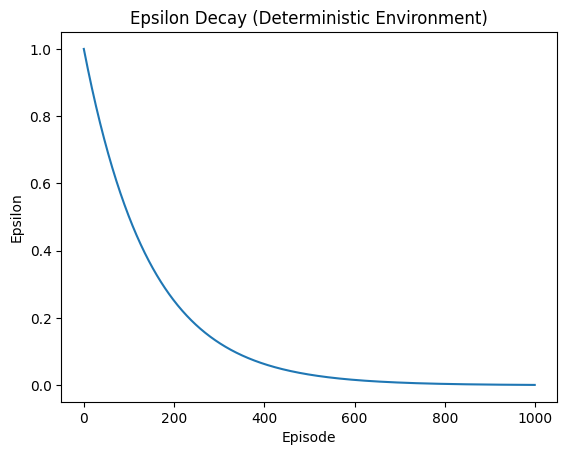

In [38]:
# Plot the epsilon decay graph
plt.plot(epsilon_history)
plt.title('Epsilon Decay (Deterministic Environment)')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

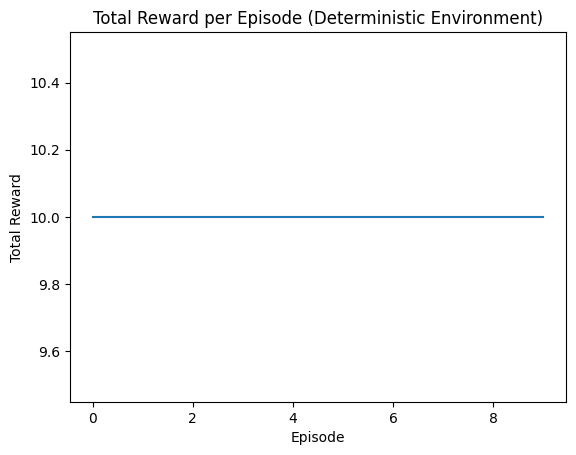

In [39]:
# Run your environment for at least 10 episodes, where the agent chooses only greedy actions from the learned policy
sarsa_agent.epsilon = 0
reward_per_episode, _ = sarsa_agent.train(10)

# Plot the total reward per episode graph
plt.plot(reward_per_episode)
plt.title('Total Reward per Episode (Deterministic Environment)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

### Stochastic Environment

In [40]:
# Init SARSA agent for stochastic environment
sarsa_agent = SARSAAgent(s_env)

In [41]:
# print init q-table for stochastic environment
print(sarsa_agent.q_table)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [42]:
# Train the agent
reward_per_episode, epsilon_history = sarsa_agent.train(1000)

# Save the Q-table
sarsa_agent.save_q_table('sarsa_q_table_sto.pkl')

# Load the Q-table
sarsa_agent.load_q_table('sarsa_q_table_sto.pkl')

In [43]:
# print trained q-table for stochastic environment
print(sarsa_agent.q_table)

[[-1.01879442  1.58230663  4.45230366  1.37497716]
 [ 1.94764431  3.75056152  1.93878957  2.13616456]
 [ 0.77012163 -0.25334349  0.03211394  4.58090586]
 [ 6.40155963 -0.10899064 -0.38955763  0.04149697]
 [-1.36337458 -0.85136434  1.94820446 -1.45986554]
 [-1.37951471  4.18670289  2.62617326 -1.19382948]
 [ 0.97146628 -0.18514759  8.04898122  0.35543725]
 [ 9.47643616 -0.06493291  2.15545849 -0.22274925]
 [-1.38522878 -1.13121826 -1.6051622  -1.39403569]
 [-1.01916381 -0.74017725  3.66535366 -0.82059311]
 [ 0.39010574  0.07176459  8.73015617 -0.58718629]
 [ 0.          0.          0.          0.        ]]


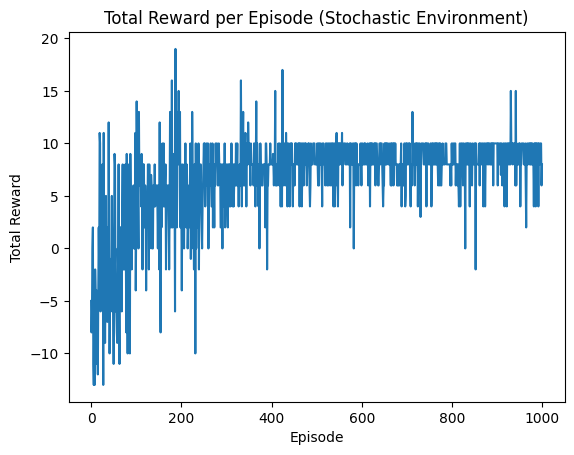

In [44]:
# Plot the total reward per episode graph
plt.plot(reward_per_episode)
plt.title('Total Reward per Episode (Stochastic Environment)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

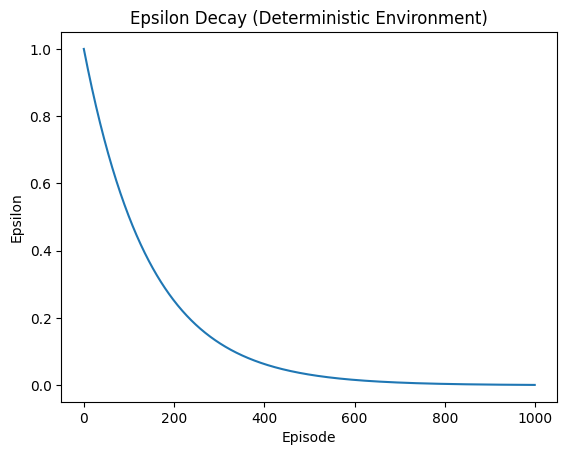

In [45]:
# Plot the epsilon decay graph
plt.plot(epsilon_history)
plt.title('Epsilon Decay (Deterministic Environment)')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

## Part 3: Solve Stock Trading Environment

### Stock Trading Environment 

In [ ]:
# Defining the Stock Trading Environment.
"""DON'T MAKE ANY CHANGES TO THE ENVIRONMENT."""


class StockTradingEnvironment(gymnasium.Env):
    """This class implements the Stock Trading environment."""

    def __init__(self, file_path, train=True, number_of_days_to_consider=10):
        """This method initializes the environment.

        :param file_path: - Path of the CSV file containing the historical stock data.
        :param train: - Boolean indicating whether the goal is to train or test the performance of the agent.
        :param number_of_days_to_consider = Integer representing the number of days the for which the agent
                considers the trend in stock price to make a decision."""

        self.file_path = file_path
        self.stock_data = pd.read_csv(self.file_path)
        self.train = train

        # Splitting the data into train and test datasets.
        self.training_stock_data = self.stock_data.iloc[:int(0.8 * len(self.stock_data))]
        self.testing_stock_data = self.stock_data.iloc[int(0.8 * len(self.stock_data)):].reset_index()

        self.observation_space = spaces.Discrete(4)
        self.action_space = spaces.Discrete(3)

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # This defines the number of days for which the agent considers the data before taking an action.
        self.number_of_days_to_consider = number_of_days_to_consider
        # The maximum timesteps the agent will take before the episode ends.
        if self.train:
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider
        else:
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider
        # Initializing the number of steps taken to 0.
        self.timestep = 0
        self.reset()

    def reset(self):
        """This method resets the environment and returns the observation.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.

                 info: - info: - A dictionary that can be used to provide additional implementation information."""

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # Initializing the number of steps taken to 0.
        self.timestep = 0

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector that will be passed to the agent.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector.
            observation = [price_increase, stock_held]

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        info = None

        return observation, info

    def step(self, action):
        """This method implements what happens when the agent takes the action to Buy/Sell/Hold.

        :param action: - Integer in the range 0 to 2 inclusive.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.
                 reward: - Integer/Float value that's used to measure the performance of the agent.
                 terminated: - Boolean describing whether the episode has terminated.
                 truncated: - Boolean describing whether a truncation condition outside the scope of the MDP is satisfied.
                 info: - A dictionary that can be used to provide additional implementation information."""

        # We give the agent a penalty for taking actions such as buying a stock when the agent doesn't have the
        # investment capital and selling a stock when the agent doesn't have any shares.
        penalty = 0

        if self.train:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.training_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value +=\
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider]\
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        else:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.testing_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = self.training_stock_data['Open'][
                                           self.timestep + self.number_of_days_to_consider] * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        # Determining if the agent currently has shares of the stock or not.
        if self.number_of_shares > 0:
            stock_held = True
        else:
            stock_held = False

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        self.timestep += 1  # Increasing the number of steps taken by the agent by 1.

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        # Computing the total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # Appending the total account value of the list to plot the graph.
        self.total_account_value_list.append(self.total_account_value)

        # The episode terminates when the maximum timesteps have been reached.
        terminated = True if (self.timestep >= self.max_timesteps) \
            else False
        truncated = False
        info = {}

        return observation, reward, terminated, truncated, info

    def render(self, mode='human'):
        """This method renders the agent's total account value over time.

        :param mode: 'human' renders to the current display or terminal and returns nothing."""

        plt.figure(figsize=(15, 10))
        plt.plot(self.total_account_value_list, color='lightseagreen', linewidth=7)
        plt.xlabel('Days', fontsize=32)
        plt.ylabel('Total Account Value', fontsize=32)
        plt.title('Total Account Value over Time', fontsize=38)
        plt.grid()
        plt.show()

In [ ]:
# NOTE: You can adjust the parameter 'number_of_days_to_consider'

stock_trading_environment = StockTradingEnvironment('./NVDA.csv', number_of_days_to_consider=10)

### TO DO: Implement the Q-learning algorithm